In [1]:
# STEP 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
sns.set(style='whitegrid')


In [2]:
iris = load_iris()
X_raw = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target


In [3]:
def no_processing(X):
    return X

def normalize(X):
    return StandardScaler().fit_transform(X)

def pca_only(X, n_components=2):
    return PCA(n_components=n_components).fit_transform(X)

def normalize_then_pca(X, n_components=2):
    X_norm = normalize(X)
    return PCA(n_components=n_components).fit_transform(X_norm)

In [4]:
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

In [5]:
def run_kmeans(X, cluster_range, preprocessing_label):
    results = []
    for c in cluster_range:
        model = KMeans(n_clusters=c, random_state=42)
        labels = model.fit_predict(X)
        sil, ch, db = evaluate_clustering(X, labels)
        results.append({'Algorithm': 'KMeans', 'Preprocessing': preprocessing_label, 'c': c,
                        'Silhouette': sil, 'Calinski-Harabasz': ch, 'Davies-Bouldin': db})
    return results

def run_hierarchical(X, cluster_range, preprocessing_label):
    results = []
    for c in cluster_range:
        model = AgglomerativeClustering(n_clusters=c)
        labels = model.fit_predict(X)
        sil, ch, db = evaluate_clustering(X, labels)
        results.append({'Algorithm': 'Hierarchical', 'Preprocessing': preprocessing_label, 'c': c,
                        'Silhouette': sil, 'Calinski-Harabasz': ch, 'Davies-Bouldin': db})
    return results

def run_meanshift(X, preprocessing_label):
    bandwidth = estimate_bandwidth(X, quantile=0.2)
    model = MeanShift(bandwidth=bandwidth)
    labels = model.fit_predict(X)
    sil, ch, db = evaluate_clustering(X, labels)
    n_clusters = len(np.unique(labels))
    return [{
        'Algorithm': 'MeanShift', 'Preprocessing': preprocessing_label, 'c': n_clusters,
        'Silhouette': sil, 'Calinski-Harabasz': ch, 'Davies-Bouldin': db
    }]

In [6]:
cluster_range = [3, 4, 5]
all_results = []

# Define preprocessing strategies
preprocessing_methods = {
    'None': no_processing,
    'Normalization': normalize,
    'PCA': pca_only,
    'Normalization + PCA': normalize_then_pca
}

# Run each preprocessing + clustering combo
for label, preprocess in preprocessing_methods.items():
    X_processed = preprocess(X_raw)

    # KMeans
    all_results.extend(run_kmeans(X_processed, cluster_range, label))

    # Hierarchical
    all_results.extend(run_hierarchical(X_processed, cluster_range, label))

    # Mean Shift (only one run needed)
    all_results.extend(run_meanshift(X_processed, label))

In [7]:
results_df = pd.DataFrame(all_results)
results_df.sort_values(by=['Algorithm', 'Preprocessing', 'c'], inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Display results table
from IPython.display import display
display(results_df)

,Algorithm,Preprocessing,c,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,Hierarchical,None,3,0.554324,558.058041,0.656256
1,Hierarchical,None,4,0.488967,515.078906,0.795264
2,Hierarchical,None,5,0.484383,488.484904,0.820417
3,Hierarchical,Normalization,3,0.446689,222.719164,0.803467
4,Hierarchical,Normalization,4,0.400636,201.251454,0.978821
5,Hierarchical,Normalization,5,0.330587,192.681283,0.974249
6,Hierarchical,Normalization + PCA,3,0.511060,286.328664,0.705430
7,Hierarchical,Normalization + PCA,4,0.448735,254.090094,0.722612
8,Hierarchical,Normalization + PCA,5,0.404169,254.996196,0.791250
9,Hierarchical,PCA,3,0.598475,688.617548,0.560496


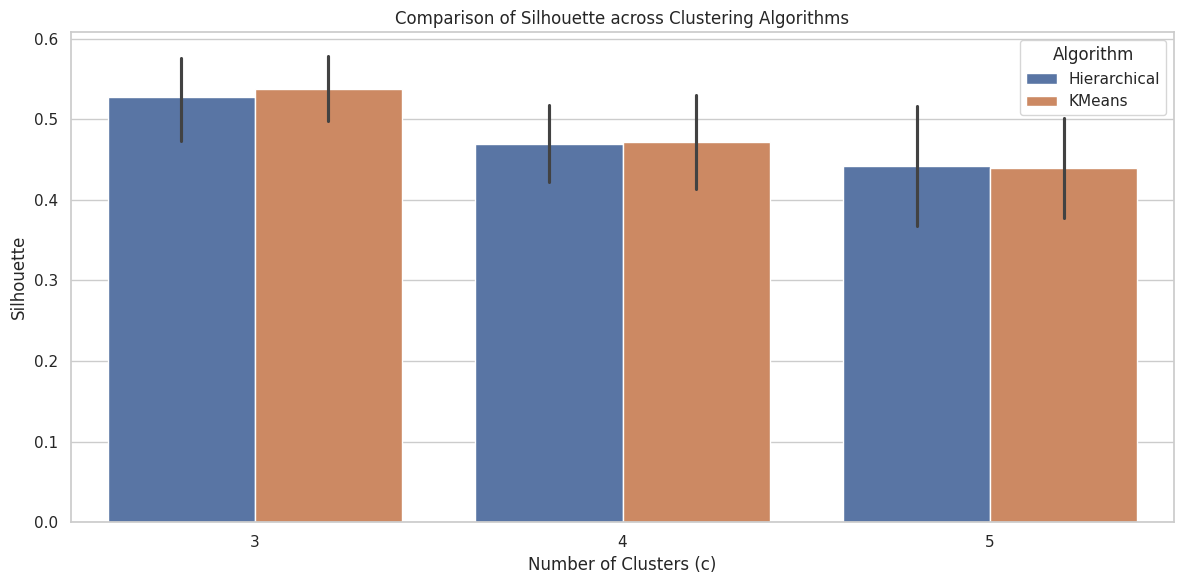

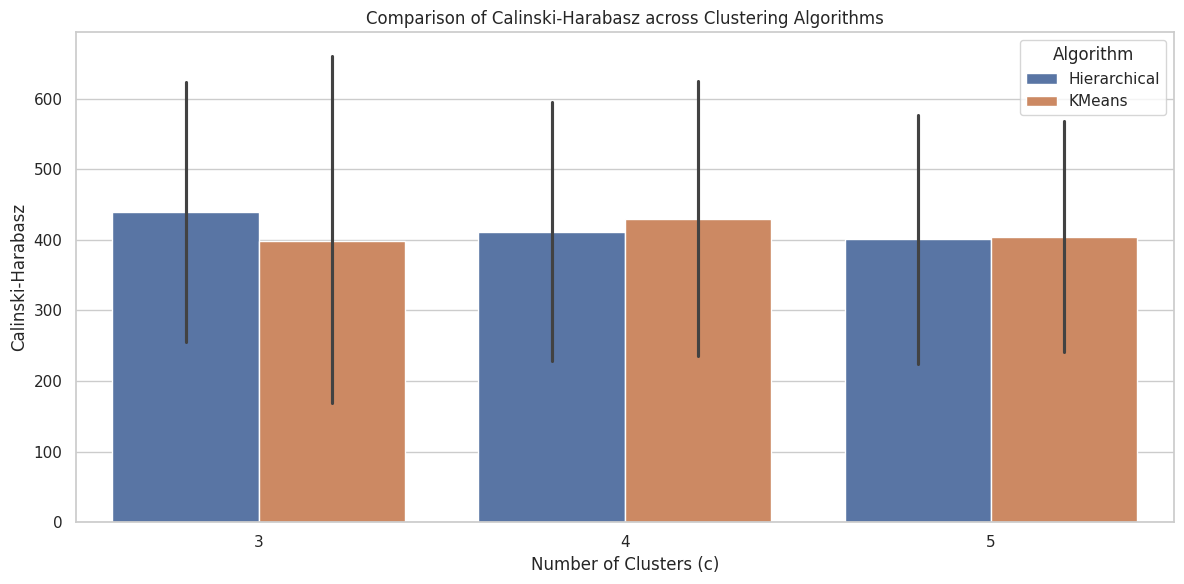

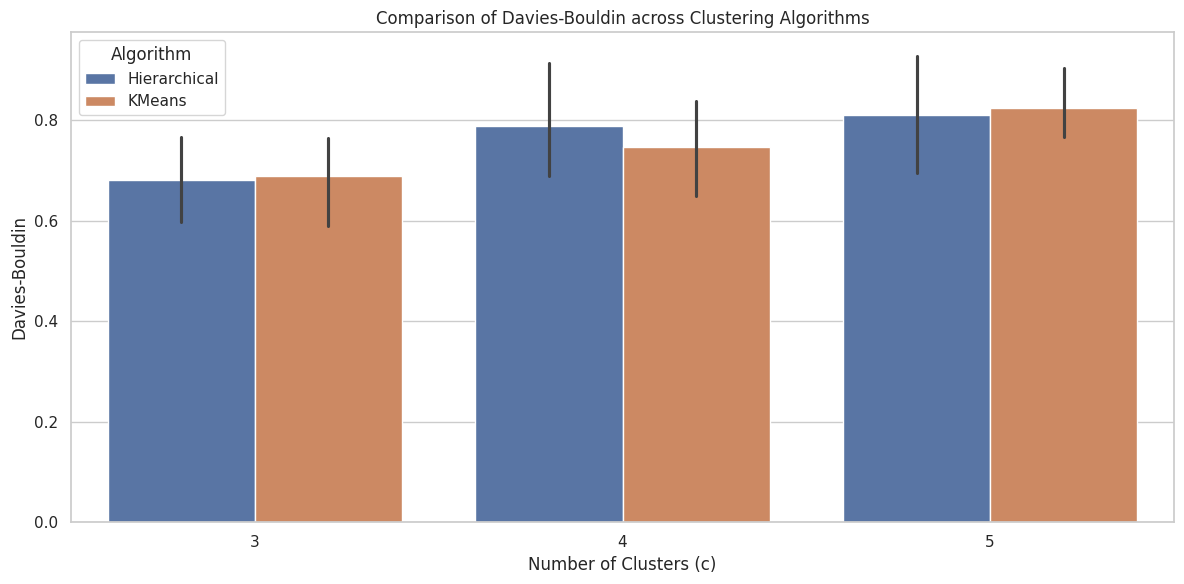

In [8]:
def plot_metric(df, metric_name):
    plt.figure(figsize=(12,6))
    sns.barplot(data=df[df['Algorithm'] != 'MeanShift'], x='c', y=metric_name, hue='Algorithm')
    plt.title(f'Comparison of {metric_name} across Clustering Algorithms')
    plt.ylabel(metric_name)
    plt.xlabel('Number of Clusters (c)')
    plt.legend(title='Algorithm')
    plt.tight_layout()
    plt.show()

plot_metric(results_df, 'Silhouette')
plot_metric(results_df, 'Calinski-Harabasz')
plot_metric(results_df, 'Davies-Bouldin')


After performing a comparative study of K-Means, Hierarchical Clustering, and Mean Shift on the Iris dataset using different preprocessing techniques, the following observations were made:

Best Performing Algorithm:

K-Means consistently achieved higher Silhouette and Calinski-Harabasz scores, especially when the number of clusters was set to 3 (which matches the actual number of species in the dataset).

Mean Shift, while not requiring predefined k, resulted in fewer clusters and often lower evaluation scores on this dataset.

Effect of Preprocessing:

Normalization improved performance in almost all cases, especially for K-Means.

PCA helped visualize data better but sometimes slightly reduced clustering quality due to dimensionality reduction.

The combination of Normalization + PCA struck a good balance between performance and interpretability.

Cluster Size (c) Impact:

The optimal number of clusters for K-Means and Hierarchical clustering was 3, aligning with the natural grouping of the Iris dataset.

Increasing c to 4 or 5 generally lowered Silhouette scores and increased Davies-Bouldin Index, indicating poorer separation between clusters.

Overall Summary:

For the Iris dataset, K-Means with Normalization gave the best overall clustering performance.

Mean Shift is useful when the number of clusters is unknown, but might not always perform best on well-separated small datasets like Iris.



```
# `# This is formatted as code`
```

